# Unphased Data Results

        R2 Score  IQS Score  Accuracy Score  AUC Score
count  22.000000  22.000000       22.000000  22.000000
mean    0.622296   0.827436        0.893280   0.857419
std     0.115266   0.046574        0.033250   0.057703
min     0.398726   0.731621        0.819095   0.687836
25%     0.557515   0.802500        0.877003   0.845340
50%     0.626345   0.823748        0.885236   0.865303
75%     0.673236   0.850117        0.914970   0.890535
max     0.855734   0.909234        0.953870   0.949132


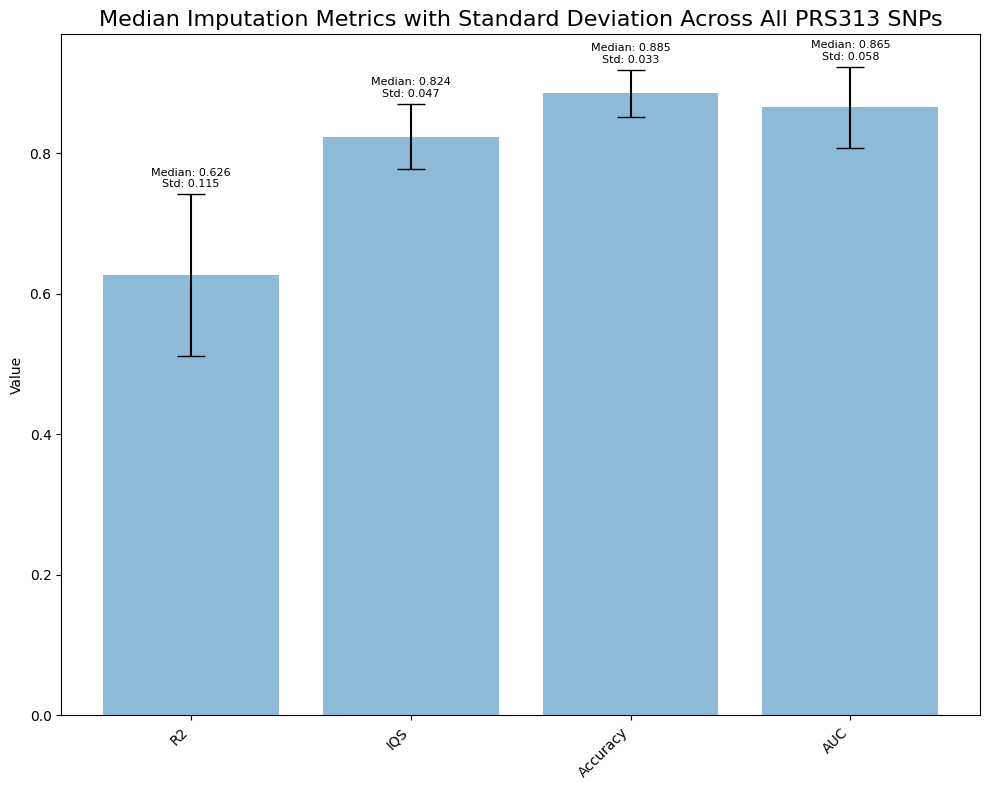

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

def read_csv_files(folder_path):
    return [pd.read_csv(os.path.join(folder_path, file_name)) 
            for file_name in os.listdir(folder_path) if file_name.endswith(".csv")]

def combine_dataframes(dataframes):
    return pd.concat(dataframes, ignore_index=True).dropna().drop(columns='Chromosome')

def calculate_summary_stats(df):
    return df.describe()

def extract_metrics(summary_stats):
    return summary_stats.loc['50%'].values, summary_stats.loc['std'].values

def plot_metrics(metrics, medians, std_devs):
    fig, ax = plt.subplots(figsize=(10, 8))
    x = range(len(metrics))
    ax.bar(x, medians, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylabel('Value')
    ax.set_title('Median Imputation Metrics with Standard Deviation Across All PRS313 SNPs', fontsize=16)
    
    for i, v in enumerate(medians):
        ax.text(i, v + std_devs[i] + 0.01, f"Median: {v:.3f}\nStd: {std_devs[i]:.3f}", ha='center', fontsize=8)
    
    fig.tight_layout()
    plt.show()

def visualize_performance(folder_path):
    metrics = ['R2', "IQS", "Accuracy", "AUC"]
    
    dataframes = read_csv_files(folder_path)
    combined_df = combine_dataframes(dataframes)
    summary_stats = calculate_summary_stats(combined_df)
    medians, std_devs = extract_metrics(summary_stats)
    
    print(summary_stats)
    
    plot_metrics(metrics, medians, std_devs)


visualize_performance("../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files")


        R2 Score  IQS Score  Accuracy Score  AUC Score
count  22.000000  22.000000       22.000000  22.000000
mean    0.542339   0.776277        0.868838   0.809592
std     0.104158   0.060190        0.040404   0.042923
min     0.334425   0.680516        0.814958   0.725949
25%     0.488316   0.740172        0.834296   0.791082
50%     0.530552   0.762916        0.864879   0.803418
75%     0.580652   0.822231        0.907719   0.827389
max     0.802341   0.877368        0.942559   0.929131


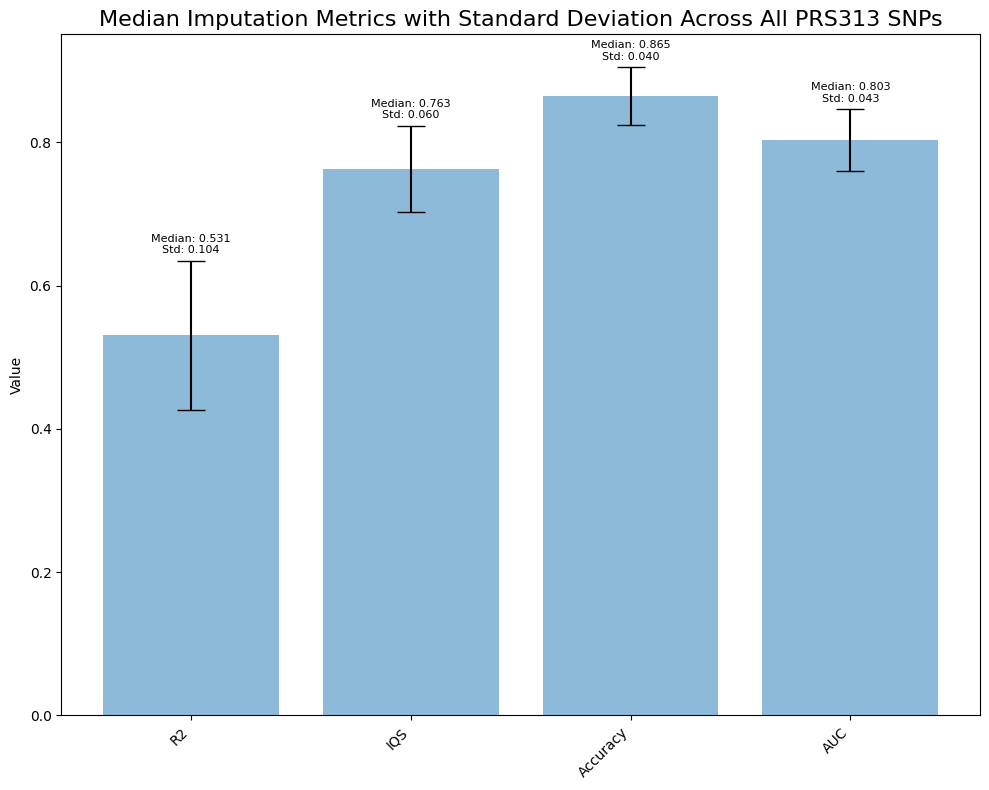

In [7]:
visualize_performance("../../../Data/model_results_unphased_all_PRS/neural_network/csv_files")

        R2 Score  IQS Score  Accuracy Score  AUC Score
count  18.000000  18.000000       18.000000  18.000000
mean    0.804347   0.920176        0.828526   0.958866
std     0.303147   0.032400        0.060317   0.016898
min    -0.162009   0.870474        0.735814   0.931645
25%     0.860185   0.896572        0.781662   0.951784
50%     0.901783   0.917560        0.821231   0.955676
75%     0.937229   0.950731        0.875227   0.971946
max     0.969473   0.967661        0.935629   0.986063


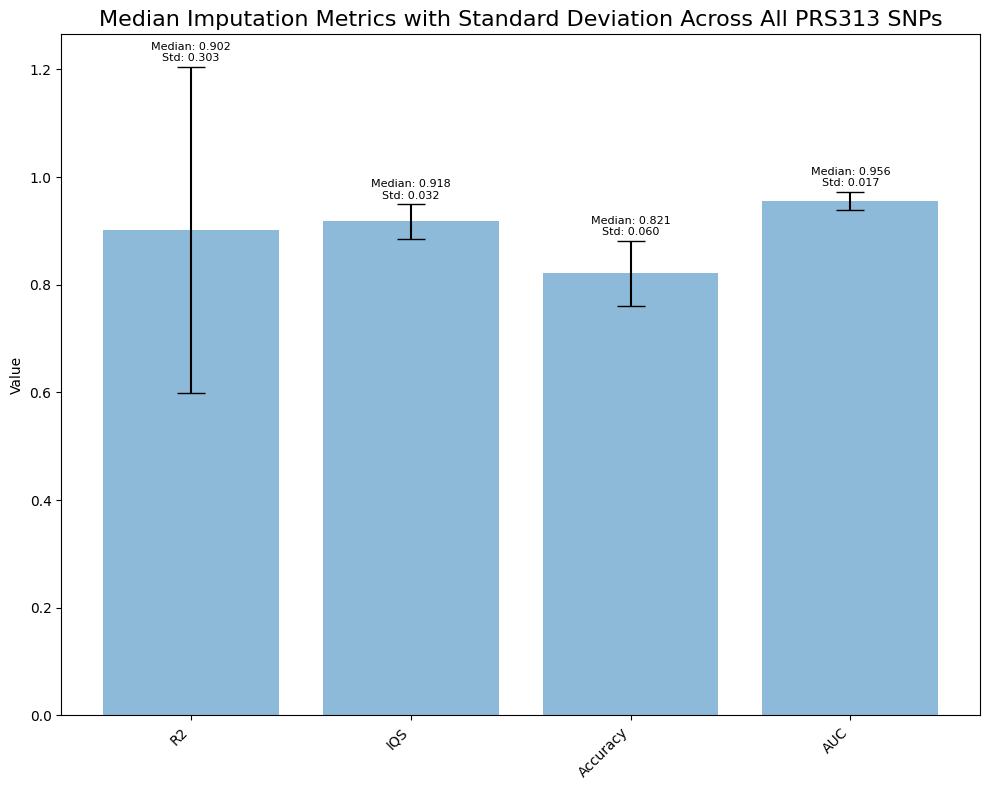

In [9]:

visualize_performance("../../../Data/model_results_unphased_all_PRS/beagle/csv_files")

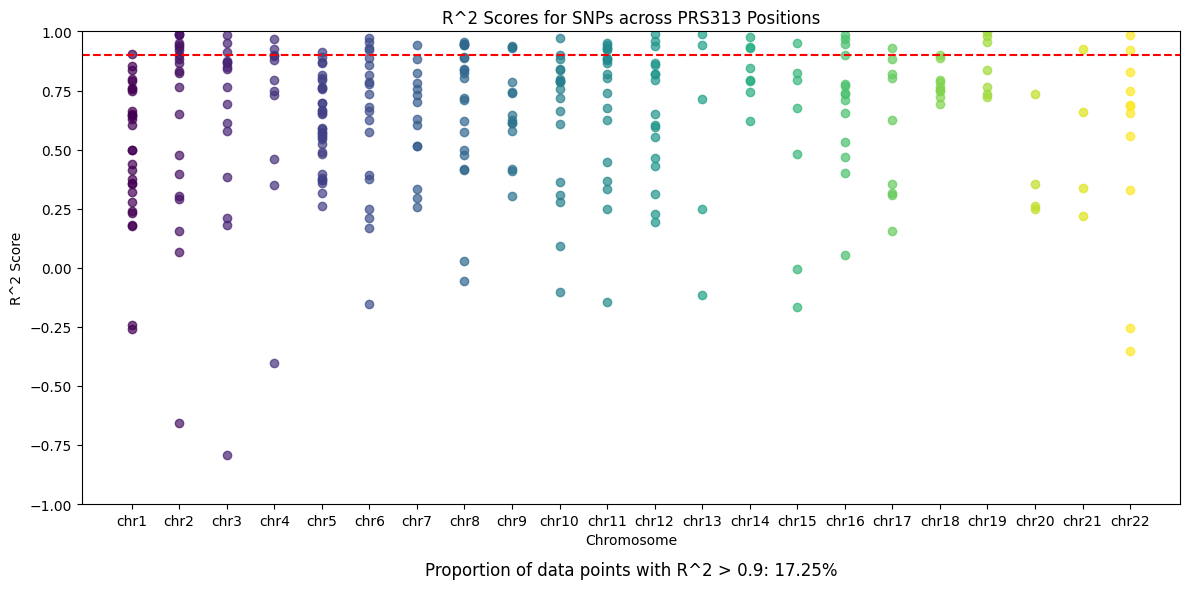

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import partial

# Define a function to read and process CSV file
def read_and_process_csv(base_dir, chr_folder):
    csv_file = os.path.join(base_dir, chr_folder, f'individual_r2_scores_{chr_folder}.csv')
    df = pd.read_csv(csv_file)
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    df['position'] = pd.to_numeric(df['position'])
    return df

# Define a function to plot data
def plot_data(ax, cmap, i, df, chr_folder):
    df['x'] = i
    ax.scatter(df['x'], df['R2 Score'], label=chr_folder, color=cmap(i), alpha=0.7)
    return (df['R2 Score'] > 0.9).sum(), len(df)

# Define a function to create the plot
def create_plot_r2(base_dir):
    chr_folders = sorted(
        (folder for folder in os.listdir(base_dir) if folder.startswith('chr')),
        key=lambda x: int(x[3:])
    )
    
    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = plt.get_cmap('viridis', len(chr_folders))

    process_folder = partial(read_and_process_csv, base_dir)
    results = [
        plot_data(ax, cmap, i, process_folder(chr_folder), chr_folder) 
        for i, chr_folder in enumerate(chr_folders)
    ]

    data_points_above_threshold, total_data_points = map(sum, zip(*results))
    proportion = data_points_above_threshold / total_data_points

    ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)
    ax.set_title('R^2 Scores for SNPs across PRS313 Positions')
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('R^2 Score')
    ax.set_xticks(range(len(chr_folders)))
    ax.set_xticklabels(chr_folders)
    ax.set_ylim(-1, 1)
    ax.text(0.5, -0.15, f'Proportion of data points with R^2 > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# Define the base directory path
base_dir = "../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files"

# Create the plot
create_plot_r2(base_dir)


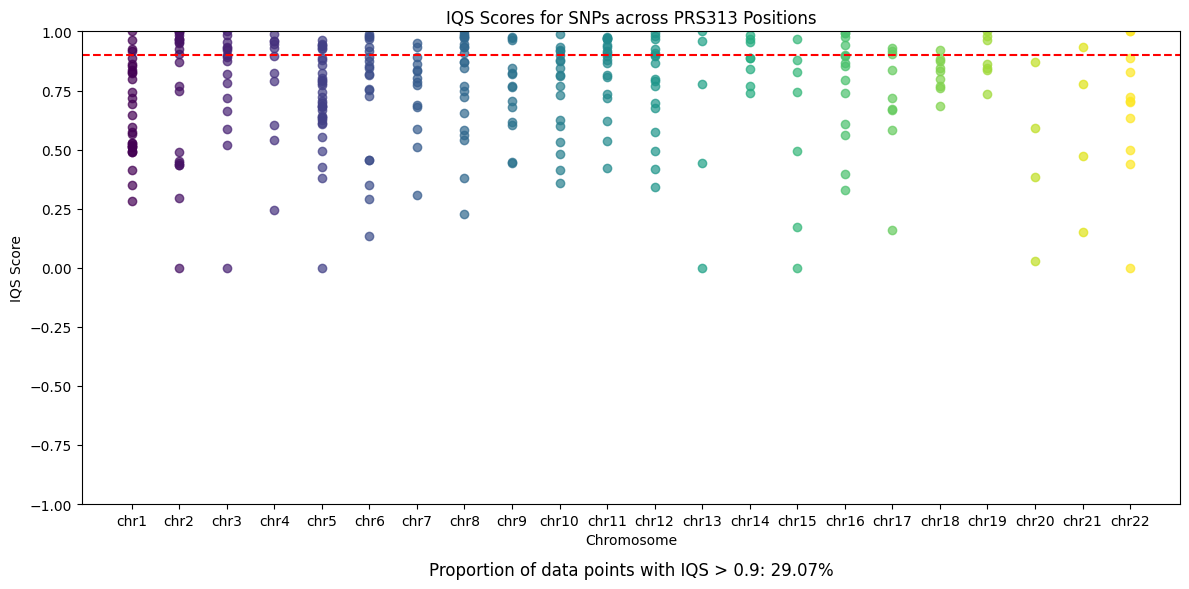

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define a function to read and process CSV file
def read_and_process_csv(base_dir, chr_folder):
    csv_file = os.path.join(base_dir, chr_folder, f'individual_iqs_scores_{chr_folder}.csv')
    df = pd.read_csv(csv_file)
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    df['position'] = pd.to_numeric(df['position'])
    return df

# Define a function to plot data
def plot_data(ax, cmap, i, df, chr_folder):
    df['x'] = i
    ax.scatter(df['x'], df['IQS Score'], label=chr_folder, color=cmap(i), alpha=0.7)
    return (df['IQS Score'] > 0.9).sum(), len(df)

# Define a function to create the plot
def create_plot(base_dir):
    chr_folders = sorted(
        (folder for folder in os.listdir(base_dir) if folder.startswith('chr')),
        key=lambda x: int(x[3:])
    )

    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = plt.get_cmap('viridis', len(chr_folders))

    total_data_points = 0
    data_points_above_threshold = 0

    for i, chr_folder in enumerate(chr_folders):
        df = read_and_process_csv(base_dir, chr_folder)
        data_above_threshold, total_data = plot_data(ax, cmap, i, df, chr_folder)
        data_points_above_threshold += data_above_threshold
        total_data_points += total_data

    proportion = data_points_above_threshold / total_data_points

    ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)
    ax.set_title('IQS Scores for SNPs across PRS313 Positions')
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('IQS Score')
    ax.set_xticks(range(len(chr_folders)))
    ax.set_xticklabels(chr_folders)
    ax.set_ylim(-1, 1)
    ax.text(0.5, -0.15, f'Proportion of data points with IQS > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# Define the base directory path
base_dir = "../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files"

# Create the plot
create_plot(base_dir)


# Unphased Data

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set the path to the folder containing the result files
folder_path = "../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files"

# Concatenate all the dataframes into a single dataframe
combined_df = pd.read_csv(folder_path + "performance_metrics.csv")

combined_df = combined_df.dropna()

# Drop the Chromosome Column
combined_df = combined_df.drop(columns='Chromosome')

# Calculate summary statistics
summary_stats = combined_df.describe()

print(summary_stats)

# Extract the median values and standard deviations
medians = summary_stats.loc['50%'].values
std_devs = summary_stats.loc['std'].values

# Create a list of metric names
metrics = ['Accuracy', 'Precision', 'Recall', 'False Positive Rate', 'AUC ROC', 'R2', "IQS"]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create a bar plot of the medians with error bars
x = range(len(metrics))
ax.bar(x, medians, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10)

# Set the x-tick labels to the metric names
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')

# Set the labels and title
ax.set_ylabel('Value')
ax.set_title('Median Imputation Metrics with Standard Deviation Across All 250 Unknown PRS313 SNPs', fontsize=16)


# Display the values of median and standard deviation on the bars
for i, v in enumerate(medians):
    ax.text(i, v + std_devs[i] + 0.01, f"Median: {v:.3f}\nStd: {std_devs[i]:.3f}", ha='center', fontsize=8)

# Adjust the layout
fig.tight_layout()

# Display the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../../Data/model_results_unphased_all_PRS/linear_regression/csv_filesperformance_metrics.csv'

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_66740/2417319771.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(chr_folders))


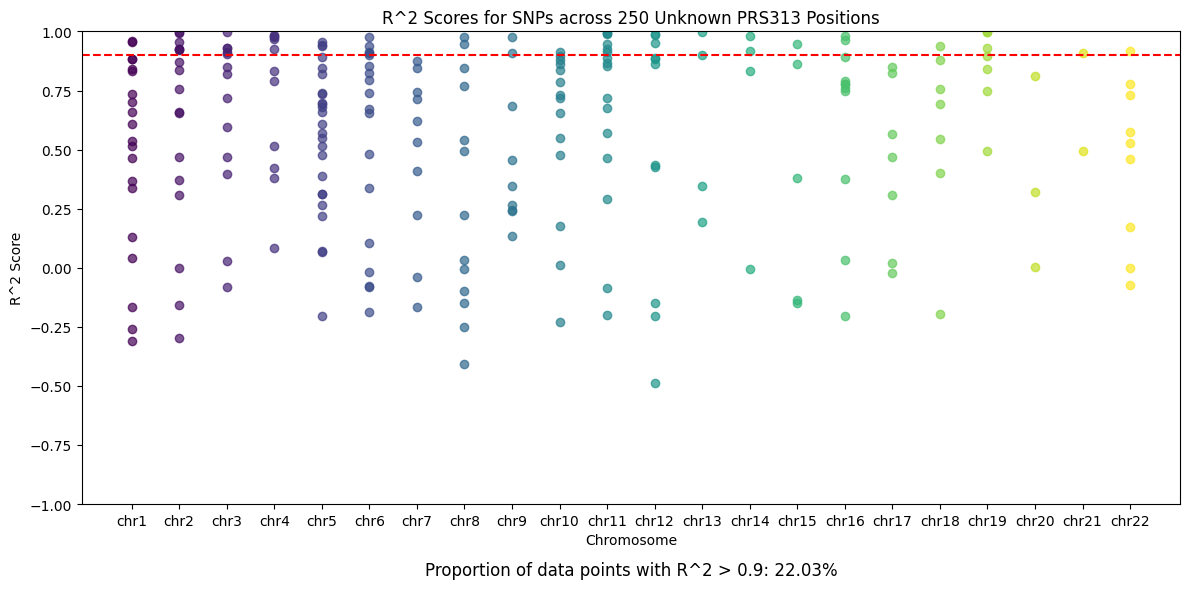

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Specify the base directory path
base_dir = '../../Data/model_results_unphased/logistic_regression/csv_files/'

# Get the list of chromosome folders
chr_folders = [folder for folder in os.listdir(base_dir) if folder.startswith('chr')]

# Sort the chromosome folders
chr_folders.sort(key=lambda x: int(x[3:]))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define a color map
cmap = plt.cm.get_cmap('viridis', len(chr_folders))

total_data_points = 0
data_points_above_threshold = 0

# Iterate over each chromosome folder
for i, chr_folder in enumerate(chr_folders):
    # Get the CSV file path
    csv_file = os.path.join(base_dir, chr_folder, 'individual_r2_scores_' + chr_folder + '.csv')
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Extract the chromosome and SNP position from the SNP column
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    
    # Convert position to numeric
    df['position'] = pd.to_numeric(df['position'])
    
    # Assign x-coordinates based on the chromosome number
    df['x'] = i
    
    # Create a scatter plot for the current chromosome
    ax.scatter(df['x'], df['R2 Score'], label=chr_folder, color=cmap(i), alpha=0.7)
    
    # Calculate the number of data points above the threshold for the current chromosome
    data_points_above_threshold += (df['R2 Score'] > 0.9).sum()
    total_data_points += len(df)

# Calculate the proportion of data points above the threshold
proportion = data_points_above_threshold / total_data_points

# Add a dashed line at 0.9
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)

# Set the title and labels
ax.set_title('R^2 Scores for SNPs across 250 Unknown PRS313 Positions')
ax.set_xlabel('Chromosome')
ax.set_ylabel('R^2 Score')

# Set the x-tick labels to the chromosome numbers
ax.set_xticks(range(len(chr_folders)))
ax.set_xticklabels(chr_folders)

# Set the y-axis limits
ax.set_ylim(-1, 1)

# Add the proportion annotation at the bottom
ax.text(0.5, -0.15, f'Proportion of data points with R^2 > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Adjust the bottom margin to make room for the text
plt.subplots_adjust(bottom=0.15)

# Display the plot
plt.show()

# All PRS313 SNPs Unphased

       Accuracy  Precision    Recall  False Positive Rate   AUC ROC  R2 Score  \
count  2.000000   2.000000  2.000000             2.000000  2.000000  2.000000   
mean   0.881390   0.884472  0.882120             0.128721  0.951866  0.397149   
std    0.025526   0.052342  0.053324             0.010173  0.019429  0.184963   
min    0.863340   0.847460  0.844414             0.121528  0.938128  0.266360   
25%    0.872365   0.865966  0.863267             0.125125  0.944997  0.331754   
50%    0.881390   0.884472  0.882120             0.128721  0.951866  0.397149   
75%    0.890414   0.902977  0.900973             0.132318  0.958735  0.462543   
max    0.899439   0.921483  0.919826             0.135915  0.965605  0.527937   

       IQS Score  
count   2.000000  
mean    0.753271  
std     0.042601  
min     0.723147  
25%     0.738209  
50%     0.753271  
75%     0.768333  
max     0.783394  


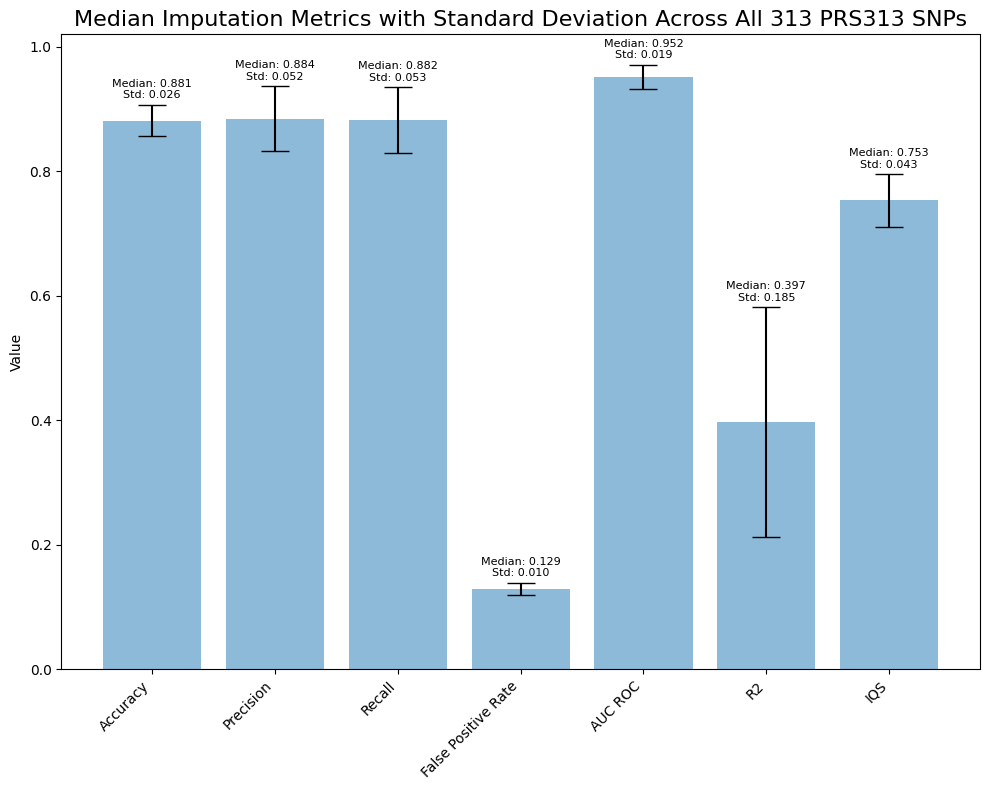

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set the path to the folder containing the result files
folder_path = "../../Data/model_results_unphased_all_PRS/logistic_regression/csv_files/"

# Concatenate all the dataframes into a single dataframe
combined_df = pd.read_csv(folder_path + "performance_metrics.csv")

combined_df = combined_df.dropna()

# Drop the Chromosome Column
combined_df = combined_df.drop(columns='Chromosome')

# Calculate summary statistics
summary_stats = combined_df.describe()

print(summary_stats)

# Extract the median values and standard deviations
medians = summary_stats.loc['50%'].values
std_devs = summary_stats.loc['std'].values

# Create a list of metric names
metrics = ['Accuracy', 'Precision', 'Recall', 'False Positive Rate', 'AUC ROC', 'R2', "IQS"]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create a bar plot of the medians with error bars
x = range(len(metrics))
ax.bar(x, medians, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10)

# Set the x-tick labels to the metric names
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')

# Set the labels and title
ax.set_ylabel('Value')
ax.set_title('Median Imputation Metrics with Standard Deviation Across All 313 PRS313 SNPs', fontsize=16)

# Display the values of median and standard deviation on the bars
for i, v in enumerate(medians):
    ax.text(i, v + std_devs[i] + 0.01, f"Median: {v:.3f}\nStd: {std_devs[i]:.3f}", ha='center', fontsize=8)

# Adjust the layout
fig.tight_layout()

# Display the plot
plt.show()

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_47403/4033810059.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(chr_folders))


30
51
67
78
112
132
146
167
181
199
218
235
240
248
255
269
278
287
294
298
302
313


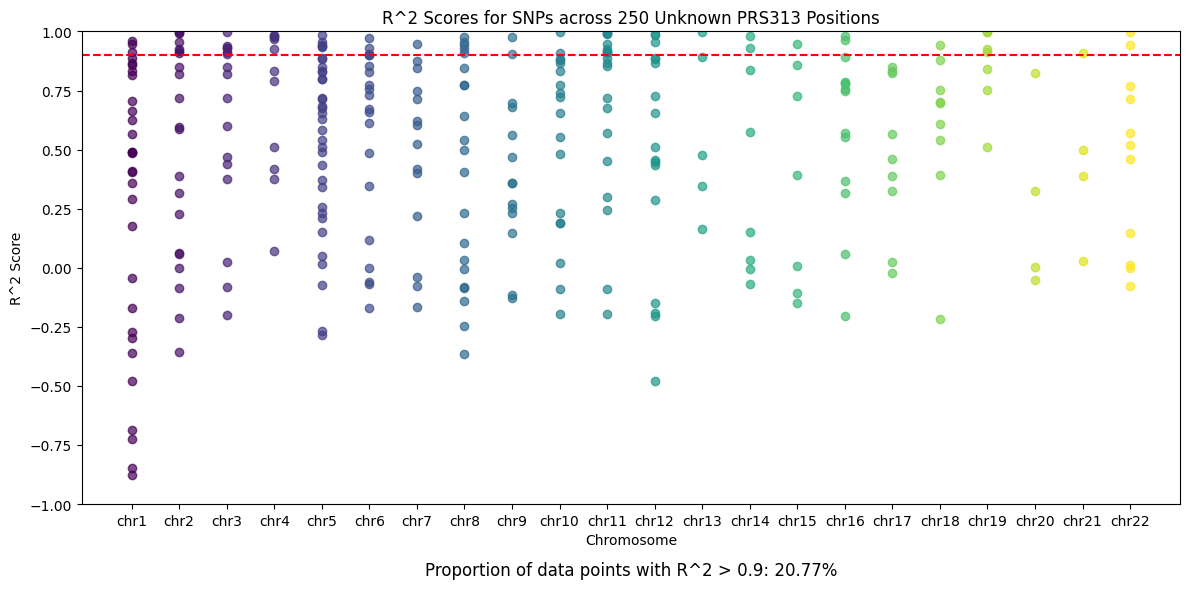

Total number of data points:  313


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Specify the base directory path
base_dir = '../../Data/model_results_unphased_all_PRS/logistic_regression/csv_files/'

# Get the list of chromosome folders
chr_folders = [folder for folder in os.listdir(base_dir) if folder.startswith('chr')]

# Sort the chromosome folders
chr_folders.sort(key=lambda x: int(x[3:]))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define a color map
cmap = plt.cm.get_cmap('viridis', len(chr_folders))

total_data_points = 0
data_points_above_threshold = 0

# Iterate over each chromosome folder
for i, chr_folder in enumerate(chr_folders):
    # Get the CSV file path
    csv_file = os.path.join(base_dir, chr_folder, 'individual_r2_scores_' + chr_folder + '.csv')
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Extract the chromosome and SNP position from the SNP column
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    
    # Convert position to numeric
    df['position'] = pd.to_numeric(df['position'])
    
    # Assign x-coordinates based on the chromosome number
    df['x'] = i
    
    # Create a scatter plot for the current chromosome
    ax.scatter(df['x'], df['R2 Score'], label=chr_folder, color=cmap(i), alpha=0.7)
    
    # Calculate the number of data points above the threshold for the current chromosome
    data_points_above_threshold += (df['R2 Score'] > 0.9).sum()
    total_data_points += len(df)
    print(total_data_points)

# Calculate the proportion of data points above the threshold
proportion = data_points_above_threshold / total_data_points

# Add a dashed line at 0.9
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)

# Set the title and labels
ax.set_title('R^2 Scores for SNPs across 250 Unknown PRS313 Positions')
ax.set_xlabel('Chromosome')
ax.set_ylabel('R^2 Score')

# Set the x-tick labels to the chromosome numbers
ax.set_xticks(range(len(chr_folders)))
ax.set_xticklabels(chr_folders)

# Set the y-axis limits
ax.set_ylim(-1, 1)

# Add the proportion annotation at the bottom
ax.text(0.5, -0.15, f'Proportion of data points with R^2 > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Adjust the bottom margin to make room for the text
plt.subplots_adjust(bottom=0.15)

# Display the plot
plt.show()

print("Total number of data points: ", total_data_points)

/var/folders/yg/982c10113957_2gb06y92y35sx509h/T/ipykernel_47403/3610222703.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(chr_folders))


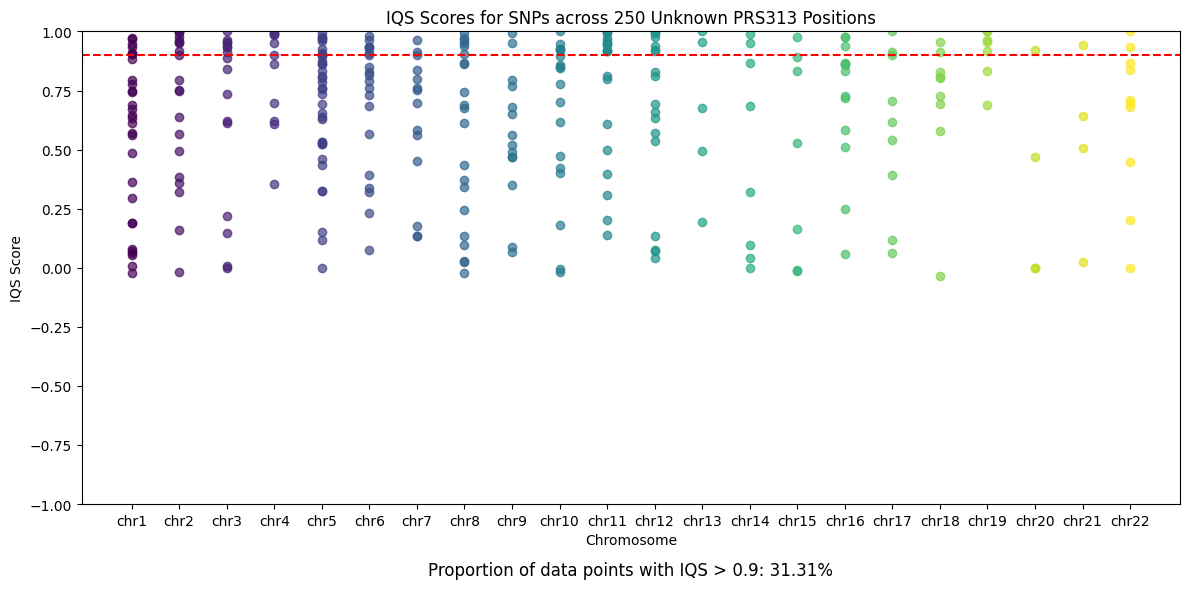

Total number of data points:  313


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Specify the base directory path
base_dir = '../../Data/model_results_unphased_all_PRS/logistic_regression/csv_files/'

# Get the list of chromosome folders
chr_folders = [folder for folder in os.listdir(base_dir) if folder.startswith('chr')]

# Sort the chromosome folders
chr_folders.sort(key=lambda x: int(x[3:]))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define a color map
cmap = plt.cm.get_cmap('viridis', len(chr_folders))

total_data_points = 0
data_points_above_threshold = 0

# Iterate over each chromosome folder
for i, chr_folder in enumerate(chr_folders):
    # Get the CSV file path
    csv_file = os.path.join(base_dir, chr_folder, 'individual_iqs_scores_' + chr_folder + '.csv')
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Extract the chromosome and SNP position from the SNP column
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    
    # Convert position to numeric
    df['position'] = pd.to_numeric(df['position'])
    
    # Assign x-coordinates based on the chromosome number
    df['x'] = i
    
    # Create a scatter plot for the current chromosome
    ax.scatter(df['x'], df['IQS Score'], label=chr_folder, color=cmap(i), alpha=0.7)
    
    # Calculate the number of data points above the threshold for the current chromosome
    data_points_above_threshold += (df['IQS Score'] > 0.9).sum()
    total_data_points += len(df)

# Calculate the proportion of data points above the threshold
proportion = data_points_above_threshold / total_data_points

# Add a dashed line at 0.9
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)

# Set the title and labels
ax.set_title('IQS Scores for SNPs across 250 Unknown PRS313 Positions')
ax.set_xlabel('Chromosome')
ax.set_ylabel('IQS Score')

# Set the x-tick labels to the chromosome numbers
ax.set_xticks(range(len(chr_folders)))
ax.set_xticklabels(chr_folders)

# Set the y-axis limits
ax.set_ylim(-1, 1)

# Add the proportion annotation at the bottom
ax.text(0.5, -0.15, f'Proportion of data points with IQS > 0.9: {proportion:.2%}', transform=ax.transAxes, fontsize=12, ha='center')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Adjust the bottom margin to make room for the text
plt.subplots_adjust(bottom=0.15)

# Display the plot
plt.show()

print("Total number of data points: ", total_data_points)